## Flüchtlingskrise Sentiment Analysis
### Emily Martin, eem80@pitt.edu

### A bit about the project
- The "refugee crisis" (or "migrant crisis") refers to the period of time, beginning roughly in 2015, when hundreds of thousands of people flooded to the EU due to conflicts in the Middle East and Africa. Germany in particular accepted large numbers of people, an act which created a lot of conflicts and polarization in both the government and the general population. These negative sentiments gave rise to the polictical party the AfD (Alternativ für Deutschland), which is very anti-immigration and nationalistic, along with organizations such as PEGIDA (Patriotic Europeans Against the Islamicisation of the Occident). One the other side there was also a huge welcome effort from both civilians and the government, with thousands of people volunteering to help and huge infrastructure changes.  I personally spent 3 months voluteering to teach English at a highschool in 2017, which was a big motivation for this project because my students were the most wonderful, kind people and the school was working hard to accommodate them, but right outside by the bus stop there was an ad for the AfD which read "Hol dir dein Land Zurück" (get your country back)...

### My hypothesis/goals
- I tried to choose newspapers the varied in their political leanings and I hypothesize that those which lean more right-wing will have more negative articles about refugees while those that lean more left-wing will have more postive sentiments. I also would like to investigate things like changes in sentiment overtime and perhaps tense usage etc.

## The data
#### Shape and acquisition
- Using the four scripts in my repo: [Süddeutsche_zeitung](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/Süddeutsche_zeitung.ipynb), [taz](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/taz.ipynb), [zeit](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/zeit.ipynb) and [Junge Freiheit](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/Junge%20Freiheit.ipynb) I was able to scrape the sites for news articles from 2015 using the search terms 'Flüchtling' (refugee) and/or 'Migranten' (migrants). 
- The actual number of articles varies widely per site because of ease of scraping and simply overall newspaper size. For Die TAZ there are 100 articles, from manually compiled links, for  Der Zeit there are 573, from links collected through their API, for Der Süddeutsche Zeitung there are 982 and for Junge Freiheit there are 76. 
- After collecting these articles in the scripts I made them into dataframes which I then pickled. However these pickled files are not available through my repo due to copywrite.

In [62]:
# Importing necessary libraries
import pandas as pd
import pickle
import nltk
import spacy
from spacy_sentiws import spaCySentiWS
from spacy.language import Language
from  spacy.lang.de.stop_words import STOP_WORDS
from spacy.tokens import Doc
import statistics
from nltk import word_tokenize
import numpy as np
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### A quick look at each source

#### Der Zeit
- Der Zeit is one of the largest weekly newspapers in Germany, it is centrist/liberal in its political leanings and kindly supports an API.

In [2]:
# Unpickle the dataframes
zeit_df = pd.read_pickle("zeit_df.pkl")
print(zeit_df.shape)
zeit_df.head()

(573, 9)


,title,href,text,release_date,word_count,sent_count,toks,types,TTR
0,Mahmood im Schilderwald,http://www.zeit.de/2015/51/fuehrerschein-fluec...,Als er vor über zehn Jahren Autofahren gelernt...,2015-12-31T02:51:37Z,1175,99,1390,608,0.437410
1,Zwei zähe Einzelgänger,http://www.zeit.de/2015/51/vorbereitung-auf-da...,"Wo Zou Lei herkommt, ist das Leben nicht leich...",2015-12-31T01:56:01Z,1155,75,1363,686,0.503302
2,Fortsetzung folgt – jetzt,http://www.zeit.de/2016/01/geschichten-2015-fo...,"Lok Leipzig ist ratlos, was aus Mario Basler w...",2015-12-30T09:00:08Z,313,26,372,229,0.615591
3,Anhaltend hohe Flüchtlingszahlen auf Balkanroute,http://www.zeit.de/gesellschaft/2015-12/slowen...,Auch zum Jahresende kommen weiter täglich Taus...,2015-12-29T22:14:02Z,362,23,402,236,0.587065
4,Laut Özoğuz schürt Union Vorurteile gegen Flüc...,http://www.zeit.de/politik/deutschland/2015-12...,Opposition und Koalitionspartner kritisieren d...,2015-12-29T08:24:55Z,379,24,447,237,0.530201


In [3]:
# A little about this dataframe:
zeit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         573 non-null    object 
 1   href          573 non-null    object 
 2   text          573 non-null    object 
 3   release_date  573 non-null    object 
 4   word_count    573 non-null    int64  
 5   sent_count    573 non-null    int64  
 6   toks          573 non-null    int64  
 7   types         573 non-null    int64  
 8   TTR           573 non-null    float64
dtypes: float64(1), int64(4), object(4)
memory usage: 40.4+ KB


In [4]:
zeit_df.describe()
# min of 1, there is at least one article where the link was broken

,word_count,sent_count,toks,types,TTR
count,573.000000,573.000000,573.000000,573.000000,573.000000
mean,567.130890,36.458988,657.005236,350.291449,0.555734
std,239.954035,16.763278,283.250269,122.933494,0.065913
min,1.000000,1.000000,1.000000,1.000000,0.360000
25%,393.000000,25.000000,447.000000,264.000000,0.513699
50%,562.000000,34.000000,654.000000,350.000000,0.552318
75%,701.000000,45.000000,812.000000,424.000000,0.587719
max,1945.000000,147.000000,2250.000000,880.000000,1.000000


### Die TAZ
-  Die TAZ (Die Tageszeitung) is a daily German newspaper with a modest circulation, it leans left-wing/green and is the most left-ist of the sources. 

In [5]:
# Unpickle and a quick look at the dataframe
taz_df = pd.read_pickle("taz_df.pkl")
print(taz_df.shape)
taz_df.head()

(100, 8)


,href,text,date,word_count,sent_count,toks,types,TTR
0,https://taz.de/Altersfeststellung-bei-Fluechtl...,Bei der Altersfeststellung minderjähriger Flüc...,2015-08-18,678,41,815,398,0.488344
1,https://taz.de/Fluechtlingspolitik-in-Deutschl...,Die Mehrheit der Deutschen lehnt grenznahe Auf...,2015-07-26,343,22,379,223,0.588391
2,https://taz.de/Kommentar-Verfassungsschutz/!50...,Die Reform des V-Leute-Wesens ist eine Charmeo...,2015-03-25,266,20,303,195,0.643564
3,https://taz.de/Erstaufnahme-in-Neumuenster/!52...,Seit dem Wochenende werden unbegleitete minder...,2015-11-02,735,41,878,429,0.488610
4,https://taz.de/Kommentar-Katastrophe-im-Mittel...,Es gibt eine völkerrechtliche Verpflichtung zu...,2015-04-20,339,23,400,237,0.592500


In [6]:
taz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        100 non-null    object 
 1   text        100 non-null    object 
 2   date        100 non-null    object 
 3   word_count  100 non-null    int64  
 4   sent_count  100 non-null    int64  
 5   toks        100 non-null    int64  
 6   types       100 non-null    int64  
 7   TTR         100 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 6.4+ KB


In [7]:
taz_df.describe()
# No broken links/problem areas

,word_count,sent_count,toks,types,TTR
count,100.000000,100.000,100.000000,100.00000,100.000000
mean,799.430000,54.560,941.110000,447.48000,0.505359
std,458.021332,37.717,547.157538,196.98959,0.063485
min,209.000000,12.000,245.000000,155.00000,0.357634
25%,495.000000,31.750,579.750000,317.25000,0.459887
50%,674.000000,41.000,802.000000,392.50000,0.495928
75%,948.000000,69.500,1104.250000,537.50000,0.555716
max,2846.000000,244.000,3347.000000,1197.00000,0.676471


### Der Süddeutsche Zeitung
- Der Süddeustche Zeitung is a daily newspaper with a very wide ciruclation (second largest after Der Zeit), it leans left-liberal.

In [8]:
# Unpickle and aa quick look at the data
sz_df = pd.read_pickle("sz_df.pkl")
print(sz_df.shape)
sz_df.head()

(990, 8)


,href,text,date,word_count,sent_count,toks,types,TTR
0,https://www.sueddeutsche.de/politik/fluechtlin...,Die europäische Flüchtlingskrise hat den Norde...,"9. September 2015, 17:25 Uhr",923,60,1051,473,0.450048
1,https://www.sueddeutsche.de/politik/fluechtlin...,Berlin (dpa) - Bilder rechtsextremer Ausschrei...,"26. August 2015, 8:00 Uhr",649,48,797,456,0.572146
2,https://www.sueddeutsche.de/politik/polen-angs...,Erzbischof Stanisław Gądecki ist seinem Chef v...,"9. September 2015, 19:05 Uhr",330,19,376,234,0.622340
3,https://www.sueddeutsche.de/politik/migration-...,München/Berlin (dpa) - Die Behörden in Deutsch...,"12. September 2015, 15:02 Uhr",572,38,681,357,0.524229
4,https://www.sueddeutsche.de/politik/internatio...,Riad (dpa) - Außenminister Frank-Walter Steinm...,"19. Oktober 2015, 12:47 Uhr",68,4,80,63,0.787500


In [9]:
sz_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        990 non-null    object 
 1   text        990 non-null    object 
 2   date        990 non-null    object 
 3   word_count  990 non-null    int64  
 4   sent_count  990 non-null    int64  
 5   toks        990 non-null    int64  
 6   types       990 non-null    int64  
 7   TTR         990 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 69.6+ KB


In [10]:
sz_df.describe()
# Fairly short articles

,word_count,sent_count,toks,types,TTR
count,990.000000,990.000000,990.000000,990.000000,990.000000
mean,320.090909,20.450505,372.702020,208.315152,0.647938
std,265.585881,17.888687,310.979566,140.115162,0.123858
min,12.000000,1.000000,13.000000,13.000000,0.387226
25%,82.000000,6.000000,94.000000,75.000000,0.545873
50%,244.500000,15.000000,285.000000,173.500000,0.626368
75%,516.000000,31.000000,604.000000,327.000000,0.765629
max,2766.000000,189.000000,3241.000000,1255.000000,1.000000


### Junge Freiheit
-  Junge Freiheit is a small weekly newspaper with fairly strong right-wing leanings

In [11]:
# Unpickle and a quick look at the data
jf_df = pd.read_pickle("jf_df.pkl")
print(jf_df.shape) # This is the smallest sample
jf_df.head()

(76, 8)


,href,text,date,word_count,sent_count,toks,types,TTR
0,https://jungefreiheit.de/kultur/gesellschaft/2...,Um ihn herum hängen Arbeiter gerade die Weihna...,19. November 2015,1348,77,1569,658,0.419375
1,https://jungefreiheit.de/politik/deutschland/2...,POTSDAM. Brandenburgs AfD-Chef Alexander Gaula...,18. November 2015,385,20,456,281,0.616228
2,https://jungefreiheit.de/debatte/kommentar/201...,Die Norwegerin Linda Hagen ist immer noch ganz...,05. November 2015,171,7,203,152,0.748768
3,https://jungefreiheit.de/politik/deutschland/2...,"ERFURT. Asylbewerber, die mit der Deutschen Ba...",04. November 2015,191,12,227,157,0.691630
4,https://jungefreiheit.de/politik/ausland/2015/...,TRIPOLIS. Der libysche „Allgemeine Volkskongre...,04. November 2015,262,17,307,181,0.589577


In [12]:
jf_df.info()
# All non-null, which is good. Can't really afford to lose more articles from this source

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        76 non-null     object 
 1   text        76 non-null     object 
 2   date        76 non-null     object 
 3   word_count  76 non-null     int64  
 4   sent_count  76 non-null     int64  
 5   toks        76 non-null     int64  
 6   types       76 non-null     int64  
 7   TTR         76 non-null     float64
dtypes: float64(1), int64(4), object(3)
memory usage: 5.3+ KB


In [13]:
jf_df.describe()

,word_count,sent_count,toks,types,TTR
count,76.000000,76.000000,76.000000,76.000000,76.000000
mean,469.921053,26.750000,550.736842,296.605263,0.586567
std,337.462759,18.807179,390.707269,172.371775,0.079762
min,126.000000,6.000000,150.000000,117.000000,0.419375
25%,194.500000,12.750000,229.750000,147.000000,0.531144
50%,343.500000,18.000000,408.500000,228.000000,0.585985
75%,747.500000,36.500000,860.500000,442.250000,0.645009
max,1348.000000,86.000000,1569.000000,725.000000,0.780000


## Sentiment Analysis
- Using SpaCy to build a pipeline, including an add on package [sentiws](https://spacy.io/universe/project/spacy-sentiws) that has sentiment scores for German words. 

In [14]:
# Building a big dataframe with all the articles, adding a column for source.
zeit_df.rename(columns={'release_date':'date'}, inplace=True) # This one didn't match the others
zeit_df = zeit_df.drop(columns=['title']) # no other had title, so it did not fit
zeit_df['source'] = 'Zeit'
taz_df['source'] = 'TAZ'
sz_df['source'] = 'SZ'
jf_df['source'] = 'JF'
all_df = sz_df.append(taz_df)
all_df = all_df.append(jf_df)
all_df = all_df.append(zeit_df)
#Quick look at our new big dataframe
all_df.tail()

,href,text,date,word_count,sent_count,toks,types,TTR,source
568,http://www.zeit.de/politik/deutschland/2015-01...,Am Mittwoch um 15.37 kommt Alexander Gauland g...,2015-01-08T16:00:49Z,893,45,1055,488,0.462559,Zeit
569,http://www.zeit.de/2015/02/kreatives-berlin-to...,"Sie sagen, es sei Liebe. Als im Oktober 2014 d...",2015-01-08T09:01:28Z,705,50,825,462,0.560000,Zeit
570,http://www.zeit.de/wirtschaft/2015-01/migratio...,"ZEIT ONLINE: Herr Brücker, zahlen die öffentli...",2015-01-06T13:36:03Z,668,44,767,374,0.487614,Zeit
571,http://www.zeit.de/politik/deutschland/2015-01...,Wer ist Konrad Adam? Vor einigen Wochen hätte ...,2015-01-05T19:41:34Z,496,29,566,325,0.574205,Zeit
572,http://www.zeit.de/gesellschaft/zeitgeschehen/...,"Erst die Blue Sky M mit fast 800 Menschen, dan...",2015-01-02T18:23:42Z,581,33,662,350,0.528701,Zeit


In [15]:
# Is it all there?
all_df.info() #Beautiful!!!! Looking good

all_df['source'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 0 to 572
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        1739 non-null   object 
 1   text        1739 non-null   object 
 2   date        1739 non-null   object 
 3   word_count  1739 non-null   int64  
 4   sent_count  1739 non-null   int64  
 5   toks        1739 non-null   int64  
 6   types       1739 non-null   int64  
 7   TTR         1739 non-null   float64
 8   source      1739 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 135.9+ KB


SZ      990
Zeit    573
TAZ     100
JF       76
Name: source, dtype: int64

In [16]:
# Initializing nlp pipeline with German
nlp = spacy.load("de_core_news_sm", disable=['ner']) #Don't need entity recognition

# Work around because sentiws is based on spacy 2.0, this makes it work with 3.0. Looks weird (since I don't 
# actually do anything to the doc, but otherwise it throws up many error messages)
@Language.component("sentiws")
def my_component(doc):
    return doc

Language.component("my_component2", func=my_component)

sentiws = spaCySentiWS(sentiws_path='/Users/emilymartin/Documents/data/SentiWS_v2')

nlp.add_pipe('sentiws')
doc = nlp('Die Dummheit der Unterwerfung blüht in hübschen Farben.') #the stupidity of the submission blooms in pretty colors
Doc.set_extension("sentiws", default=True)

# An example of how sentiws works and a look at the pipeline
for token in doc:
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))
    
print(nlp.pipeline)

Die, None, DET
Dummheit, -0.4877, NOUN
der, None, DET
Unterwerfung, -0.3279, NOUN
blüht, 0.2028, VERB
in, None, ADP
hübschen, 0.4629, ADJ
Farben, None, NOUN
., None, PUNCT
[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7f813c472770>), ('tagger', <spacy.pipeline.tagger.Tagger object at 0x7f813c47bf50>), ('morphologizer', <spacy.pipeline.morphologizer.Morphologizer object at 0x7f813c47bfb0>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7f81437bfb40>), ('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x7f813c4dbeb0>), ('lemmatizer', <spacy.pipeline.lemmatizer.Lemmatizer object at 0x7f813c535870>), ('sentiws', <function my_component at 0x7f813c44c7a0>)]


In [17]:
# Getting the sentiment score for all the words that have them after the text had been passed through the pipeline
# and stopwords had been removed
stop = STOP_WORDS #German stop words
url_lst = all_df.href.tolist()
doc_lst = all_df.text.tolist()

# Initializing empty dict, easy to convert to df
scores = {}
# zip function = super cool and useful!
for url, doc in zip(url_lst, nlp.pipe(doc_lst)):
    x = [token._.sentiws for token in doc if not token.is_stop if token._.sentiws]
    scores[url] = x

#scores
# hmmm I wonder what the 0.004 score is, smoothing? Most common, but that common?

In [18]:
# getting the mean of the scores for each article 
for k, v in scores.items():
    try:
        scores[k] = statistics.mean(v)
    except:
        scores[k] = 0.0
        pass
#scores

In [19]:
# Adding the scores to the dataframe! mapping using href
all_df['score']= all_df['href'].map(scores)
all_df.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
0,https://www.sueddeutsche.de/politik/fluechtlin...,Die europäische Flüchtlingskrise hat den Norde...,"9. September 2015, 17:25 Uhr",923,60,1051,473,0.450048,SZ,-0.032131
1,https://www.sueddeutsche.de/politik/fluechtlin...,Berlin (dpa) - Bilder rechtsextremer Ausschrei...,"26. August 2015, 8:00 Uhr",649,48,797,456,0.572146,SZ,0.024088
2,https://www.sueddeutsche.de/politik/polen-angs...,Erzbischof Stanisław Gądecki ist seinem Chef v...,"9. September 2015, 19:05 Uhr",330,19,376,234,0.622340,SZ,0.038940
3,https://www.sueddeutsche.de/politik/migration-...,München/Berlin (dpa) - Die Behörden in Deutsch...,"12. September 2015, 15:02 Uhr",572,38,681,357,0.524229,SZ,-0.061366
4,https://www.sueddeutsche.de/politik/internatio...,Riad (dpa) - Außenminister Frank-Walter Steinm...,"19. Oktober 2015, 12:47 Uhr",68,4,80,63,0.787500,SZ,-0.089533


In [20]:
# Defining a function for assigning neg/pos to the scores and passing the column through
def neg_pos(score):
    if score < 0.0:
        return 'neg'
    elif score > 0.0:
        return 'pos'
    else:
        return None

all_df.score = all_df['score'].map(lambda s: neg_pos(s))
all_df.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
0,https://www.sueddeutsche.de/politik/fluechtlin...,Die europäische Flüchtlingskrise hat den Norde...,"9. September 2015, 17:25 Uhr",923,60,1051,473,0.450048,SZ,neg
1,https://www.sueddeutsche.de/politik/fluechtlin...,Berlin (dpa) - Bilder rechtsextremer Ausschrei...,"26. August 2015, 8:00 Uhr",649,48,797,456,0.572146,SZ,pos
2,https://www.sueddeutsche.de/politik/polen-angs...,Erzbischof Stanisław Gądecki ist seinem Chef v...,"9. September 2015, 19:05 Uhr",330,19,376,234,0.622340,SZ,pos
3,https://www.sueddeutsche.de/politik/migration-...,München/Berlin (dpa) - Die Behörden in Deutsch...,"12. September 2015, 15:02 Uhr",572,38,681,357,0.524229,SZ,neg
4,https://www.sueddeutsche.de/politik/internatio...,Riad (dpa) - Außenminister Frank-Walter Steinm...,"19. Oktober 2015, 12:47 Uhr",68,4,80,63,0.787500,SZ,neg


In [21]:
# A look at the positive articles
pos = all_df[all_df.score == 'pos'] 
pos.head()   

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
1,https://www.sueddeutsche.de/politik/fluechtlin...,Berlin (dpa) - Bilder rechtsextremer Ausschrei...,"26. August 2015, 8:00 Uhr",649,48,797,456,0.572146,SZ,pos
2,https://www.sueddeutsche.de/politik/polen-angs...,Erzbischof Stanisław Gądecki ist seinem Chef v...,"9. September 2015, 19:05 Uhr",330,19,376,234,0.622340,SZ,pos
6,https://www.sueddeutsche.de/muenchen/landkreis...,Weihnachten werden viele Flüchtlinge und ihre ...,"22. November 2015, 18:51 Uhr",366,19,423,229,0.541371,SZ,pos
11,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Immer mehr Flüchtlinge erreiche...,"12. November 2015, 16:00 Uhr",211,12,253,156,0.616601,SZ,pos
29,https://www.sueddeutsche.de/politik/fluechtlin...,Osnabrück (dpa) - Flüchtlingskoordinator Peter...,"14. November 2015, 17:07 Uhr",88,6,100,80,0.800000,SZ,pos


In [22]:
# Looking at a specifc example to see if it fits expectations 
pos.text[12][:2000]
# I would agree this is postive, parts are heartwarming at least. It is about a refugee house and some of the 
# residents experiences and daily lives. 

'Im Gelben Haus in Sigmaringen in Baden-Württemberg leben 300 Menschen in 60 Zimmern. Zusammen sein nach der Flucht – wie geht das? In unserem Abschnitt gibt es vier Zimmer. Darin leben fast 30 Menschen – alles wird genau zugeteilt.  Foto: dpa Ein Haus am Stadtrand von Sigmaringen, einer Stadt in der südwestdeutschen Provinz, gelegen zwischen Rottweil und Biberach. Das Haus ist gelb, deshalb heißt es auch so: das Gelbe Haus. Es beherbergt Flüchtlinge, das Landratsamt betreibt es, die Caritas kümmert sich. Drin: Das Gebäude beherbergt rund 300 Flüchtlinge in ungefähr 60 Räumen, die mit Stockbetten ausgestattet sind. Es leben dort Menschen, die allein gekommen sind, und Familien; die Bewohner kommen vor allem aus Afrika, dem Nahen Osten und aus Asien. Das Haus steht auf einem ehemaligen Militärgelände, es hat einen riesigen Keller. Einige der Bewohner warten auf ihre Pässe, andere auf eine Arbeitserlaubnis. Wieder anderen droht die Abschiebung. Die Zimmer: In jedem Zimmer wohnen sechs bi

In [23]:
# Quick looks at negative df (this one is muuuuch bigger)
neg = all_df[all_df.score == 'neg'] 
neg.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
0,https://www.sueddeutsche.de/politik/fluechtlin...,Die europäische Flüchtlingskrise hat den Norde...,"9. September 2015, 17:25 Uhr",923,60,1051,473,0.450048,SZ,neg
3,https://www.sueddeutsche.de/politik/migration-...,München/Berlin (dpa) - Die Behörden in Deutsch...,"12. September 2015, 15:02 Uhr",572,38,681,357,0.524229,SZ,neg
4,https://www.sueddeutsche.de/politik/internatio...,Riad (dpa) - Außenminister Frank-Walter Steinm...,"19. Oktober 2015, 12:47 Uhr",68,4,80,63,0.787500,SZ,neg
5,https://www.sueddeutsche.de/politik/fluechtlin...,Nürnberg (dpa) - Mit einer Protestkundgebung v...,"17. August 2015, 13:53 Uhr",73,5,88,64,0.727273,SZ,neg
8,https://www.sueddeutsche.de/politik/fluechtlin...,Gegner und Befürworter der Aufnahme von Flücht...,"12. September 2015, 19:58 Uhr",625,42,721,390,0.540915,SZ,neg


In [24]:
# an example
neg.text[122]
# This is about refugee being saved in the mediteranean, reported factually but I would not read it and think it
# was particularly negative. I might classify it as neutral myself

'Rom (dpa) - Mehr als 4000 Flüchtlinge sind nach Angaben der italienischen Küstenwache innerhalb von 24 Stunden im Mittelmeer gerettet worden. Sie stammten von 22 Schiffen und Booten, die Notsignale gesendet hatten, sagte Kapitän Marco Di Milla heute der dpa. Ein Sprecher des italienischen Büros der Internationalen Organisation für Migration nannte auf Twitter die Zahl von 4150 Flüchtlingen, die zwischen Nordafrika und Sizilien aus dem Wasser gerettet worden seien. Nach Angaben der Organisation sind seit Jahresbeginn mehr als 100\xa0000 Bootsflüchtlinge in Italien angekommen.'

<function matplotlib.pyplot.show(close=None, block=None)>

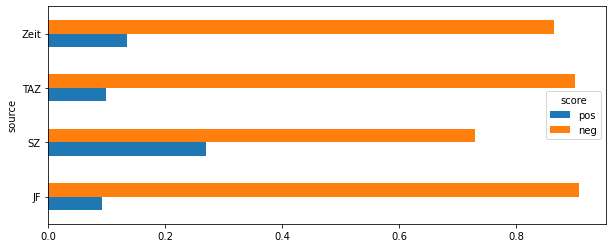

In [25]:
# But what does this all look like??
all_df.groupby('source').score.value_counts(normalize=True).unstack()[['pos', 'neg']].plot.barh(figsize=(10,4))
plt.show
# Huh, some expectations were met (JF has few postive articles), but then again so does TAZ...

In [26]:
# What does this look like in terms of numbers/percentages?
all_df.groupby('source').score.value_counts(normalize=True)

source  score
JF      neg      0.907895
        pos      0.092105
SZ      neg      0.730030
        pos      0.269970
TAZ     neg      0.900000
        pos      0.100000
Zeit    neg      0.864912
        pos      0.135088
Name: score, dtype: float64

In [27]:
all_df.groupby('source').score.value_counts()

source  score
JF      neg       69
        pos        7
SZ      neg      722
        pos      267
TAZ     neg       90
        pos       10
Zeit    neg      493
        pos       77
Name: score, dtype: int64

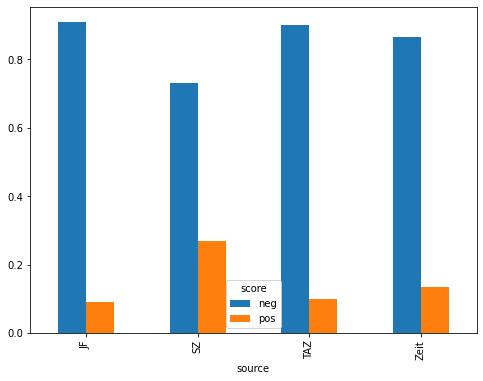

In [28]:
# Another way to vizualize
posneg_bysource = all_df.groupby('source').score.value_counts(normalize=True)
posneg_bysource

posneg_bysource.unstack(level=1).plot.bar(figsize=(8,6))
plt.show()

In [29]:
# What about change in sentiment over time? I only worked with Zeit for now because they have the most even dist
# and no variations in how the date is written
zeit_df_wsc = all_df[all_df['source'] == 'Zeit']
zeit_df_wsc

month_z = [date.split('-')[1] for date in zeit_df_wsc.date]
print(len(month_z))
zeit_df_wsc['month'] = month_z
zeit_df_wsc.tail()

573


,href,text,date,word_count,sent_count,toks,types,TTR,source,score,month
568,http://www.zeit.de/politik/deutschland/2015-01...,Am Mittwoch um 15.37 kommt Alexander Gauland g...,2015-01-08T16:00:49Z,893,45,1055,488,0.462559,Zeit,neg,01
569,http://www.zeit.de/2015/02/kreatives-berlin-to...,"Sie sagen, es sei Liebe. Als im Oktober 2014 d...",2015-01-08T09:01:28Z,705,50,825,462,0.560000,Zeit,pos,01
570,http://www.zeit.de/wirtschaft/2015-01/migratio...,"ZEIT ONLINE: Herr Brücker, zahlen die öffentli...",2015-01-06T13:36:03Z,668,44,767,374,0.487614,Zeit,neg,01
571,http://www.zeit.de/politik/deutschland/2015-01...,Wer ist Konrad Adam? Vor einigen Wochen hätte ...,2015-01-05T19:41:34Z,496,29,566,325,0.574205,Zeit,neg,01
572,http://www.zeit.de/gesellschaft/zeitgeschehen/...,"Erst die Blue Sky M mit fast 800 Menschen, dan...",2015-01-02T18:23:42Z,581,33,662,350,0.528701,Zeit,neg,01


In [30]:
# Not quite even dist, biit all months are accounted for
zeit_df_wsc['month'].value_counts()

09    81
10    79
11    69
12    68
08    51
05    44
01    40
02    32
04    32
06    28
07    28
03    21
Name: month, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

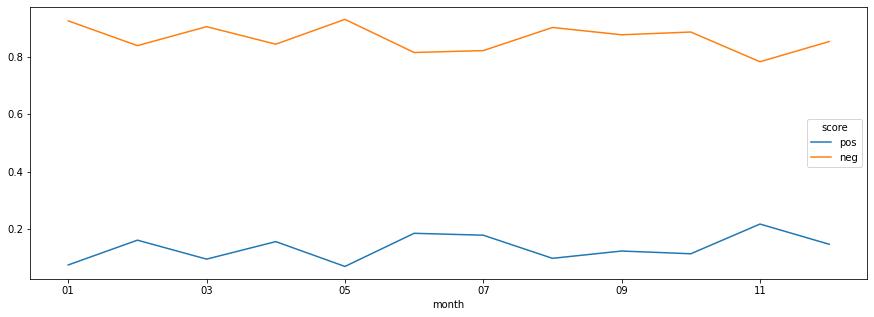

In [31]:
zeit_df_wsc.groupby('month').score.value_counts(normalize=True).unstack()[['pos', 'neg']].plot.line(figsize=(15,5))
plt.show

- April is when things really started to get crazy and the EU was trying to decide what to do with all the incoming refugees, but I dont know of anything big that led to the dips in postivity. May seems an all time low... 
- Here is a general timeline from wikipedia: https://en.wikipedia.org/wiki/Timeline_of_the_European_migrant_crisis#2015

## A deeper dive into Sentiws: flaws, function and attempts at improvement

- Overall, while Sentiws did help me achieve my goal of rudamentary sentiment analysis it has a lot of flaws. For one, there are simply not a lot of weighted words, which means that there are articles with few to no weighted words. Because of this just one word is enough to decide the positivity/negativity of an article, which does not offer a very complete picture at all. There is also the deeper issue that this method does not take anything other than individual words into consideration, which means word order, syntax, negation techniques and so on are not considered. Negation is a particularly tricky one in sentiment analysis, what if instead of saying "taking on refugees is problematic" the sentence was "taking on refugees is NOT problematic" but the only words with weights are "refugees" and "problematic"? Both sentences would be scored the same (negative) despite the fact that they express opposite sentiments.  
- In this section I will attempt to understand the function and limitations of Sentiws as well as continue my exploration of the different newspapers and their sentiments.

### First off: Flüchtling as a negative weight
- According to sentiws Flüchtling has a negative weight (-0.0048) and since this was my search term every single article includes it. According to native German speakers (and my own knowledge) this word does not have negative connotations naturally so as a first attempted quick fix I will redo the scores without it.

In [32]:
# Collecting weights without "Flüchtling"
scores_2 = {}
words = {}

for url, doc in zip(url_lst, nlp.pipe(doc_lst)):
    w = [token.text for token in doc if not token.lemma_=='Flüchtling' if not token.is_stop if token._.sentiws]
    y = [token._.sentiws for token in doc if not token.lemma_=='Flüchtling' if not token.is_stop if token._.sentiws]
    scores_2[url] = y
    words[url] = w

In [33]:
# Getting the mean for each score
for k, v in scores_2.items():
    try:
        scores_2[k] = statistics.mean(v)
    except:
        scores_2[k] = 0.0
        pass

In [34]:
# Adding it as a seperate column for comparision
all_df['score2'] = all_df['href'].map(scores_2)
# Adding a column that contains all the words that had weights per text: what the scores are based off
all_df['words'] = all_df['href'].map(words)
all_df['score2'] = all_df['score2'].map(lambda s: neg_pos(s)) #making the means neg/pos
all_df.tail()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score,score2,words
568,http://www.zeit.de/politik/deutschland/2015-01...,Am Mittwoch um 15.37 kommt Alexander Gauland g...,2015-01-08T16:00:49Z,893,45,1055,488,0.462559,Zeit,neg,neg,"[Sorgen, Gefahr, Lügen, diffamieren, Morde, Te..."
569,http://www.zeit.de/2015/02/kreatives-berlin-to...,"Sie sagen, es sei Liebe. Als im Oktober 2014 d...",2015-01-08T09:01:28Z,705,50,825,462,0.560000,Zeit,pos,pos,"[Liebe, Liebe, neues, prächtigen, aufgeben, Hö..."
570,http://www.zeit.de/wirtschaft/2015-01/migratio...,"ZEIT ONLINE: Herr Brücker, zahlen die öffentli...",2015-01-06T13:36:03Z,668,44,767,374,0.487614,Zeit,neg,neg,"[stützt, Sinn, addierte, Bildung, Arbeitslosig..."
571,http://www.zeit.de/politik/deutschland/2015-01...,Wer ist Konrad Adam? Vor einigen Wochen hätte ...,2015-01-05T19:41:34Z,496,29,566,325,0.574205,Zeit,neg,neg,"[Zufriedenheit, geführt, reine, interessiert, ..."
572,http://www.zeit.de/gesellschaft/zeitgeschehen/...,"Erst die Blue Sky M mit fast 800 Menschen, dan...",2015-01-02T18:23:42Z,581,33,662,350,0.528701,Zeit,neg,neg,"[retten, befürchten, Kurze, kurzen, ausfielen,..."


In [35]:
all_df.groupby('source').score.value_counts()

source  score
JF      neg       69
        pos        7
SZ      neg      722
        pos      267
TAZ     neg       90
        pos       10
Zeit    neg      493
        pos       77
Name: score, dtype: int64

In [36]:
all_df.groupby('source').score2.value_counts()

source  score2
JF      neg        68
        pos         8
SZ      neg       655
        pos       313
TAZ     neg        90
        pos        10
Zeit    neg       490
        pos        80
Name: score2, dtype: int64

In [40]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 0 to 572
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        1739 non-null   object 
 1   text        1739 non-null   object 
 2   date        1739 non-null   object 
 3   word_count  1739 non-null   int64  
 4   sent_count  1739 non-null   int64  
 5   toks        1739 non-null   int64  
 6   types       1739 non-null   int64  
 7   TTR         1739 non-null   float64
 8   source      1739 non-null   object 
 9   score       1735 non-null   object 
 10  score2      1714 non-null   object 
 11  words       1739 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 176.6+ KB


#### Discussion
- Removing 'Flüchtling' did not have nearly as large an impact as I was anticipating. JF gained one positive article, TAZ gained none, Zeit gained 3 and SZ gained 46 (by far the most). There are also 25 articles that have a score of 'None', as opposed to 4 from the score with 'Flüchtling' (This seems to indicate that there were 21 articles that only had 'Flüchtling' as a weight. Overall, not a rousing success

### Second attempt: A more refined labeling scheme
- Will adding more labels give a better sense of the extent of the positivity/negativity of the articles?


In [48]:
scores_3 = {}

for url, doc in zip(url_lst, nlp.pipe(doc_lst)):
    s = [token._.sentiws for token in doc if not token.lemma_=='Flüchtling' if not token.is_stop if token._.sentiws]
    scores_3[url] = s
    
# Getting the mean for each score
for k, v in scores_3.items():
    try:
        scores_3[k] = statistics.mean(v)
    except:
        scores_3[k] = 0.0
        pass
    
all_df['score3'] = all_df['href'].map(scores_3)

In [49]:
# adding very neg, very pos and neutral as labels
# The cutoffs were chosen by looking at samples of the data for the most frequent range, ideally it would be wider
# but most articles have fairly low scores (between 0.00something and 0.2something)
# neutral gets rid of None types
def ref_neg_pos(score):
    if score > 0.199:
        return 'very pos'
    elif score > 0.00 and score < 0.199:
        return 'pos'
    elif score < 0.00 and score > -0.199:
        return 'neg'
    elif score <= -0.199:
        return 'very neg'       
    else:
        return 'neut'


In [50]:
all_df.score3 = all_df['score3'].map(lambda s: ref_neg_pos(s))
all_df.sample(5)

,href,text,date,word_count,sent_count,toks,types,TTR,source,score,score2,words,score3
769,https://www.sueddeutsche.de/muenchen/wolfratsh...,Die Zahlen ändern sich laufend: Zum Stichtag 2...,"15. Juli 2015, 19:00 Uhr",138,11,163,118,0.723926,SZ,neg,pos,[schaffen],pos
27,https://jungefreiheit.de/politik/deutschland/2...,BERLIN. Bundesinnenminister Thomas de Maizière...,14. April 2015,289,17,371,203,0.547170,JF,neg,neg,"[friedlichen, Revolution, bedenken, bewirken, ...",neg
22,https://taz.de/Braende-in-Fluechtlingsunterkue...,Bis Ende Oktober wurden 78 Flüchtlingsunterkün...,2015-10-30,651,57,772,423,0.547927,TAZ,neg,neg,"[fehlt, zerstört, Feuer, Sicherheit, Angriff, ...",neg
701,https://www.sueddeutsche.de/muenchen/erding/er...,Seit zwei Wochen wird mitten im Fliegerhorst E...,"5. Oktober 2015, 18:11 Uhr",508,29,590,323,0.547458,SZ,pos,pos,"[erklärte, erhalten, zurückhalten, kürzerer, Ü...",pos
136,http://www.zeit.de/2015/44/fluechtlinge-willko...,Was wird über diese Tage im Oktober einmal in ...,2015-11-01T13:49:51Z,956,59,1146,566,0.493892,Zeit,neg,neg,"[Versagen, sinken, Kälte, wirksame, Freiheit, ...",neg


In [46]:
all_df.groupby('source').score3.value_counts()
# Still mostly grouped into neg/pos

source  score3  
JF      neg          61
        pos           8
        very neg      7
SZ      neg         565
        pos         297
        very neg     90
        neut         22
        very pos     16
TAZ     neg          86
        pos          10
        very neg      4
Zeit    neg         463
        pos          80
        very neg     27
        neut          3
Name: score3, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

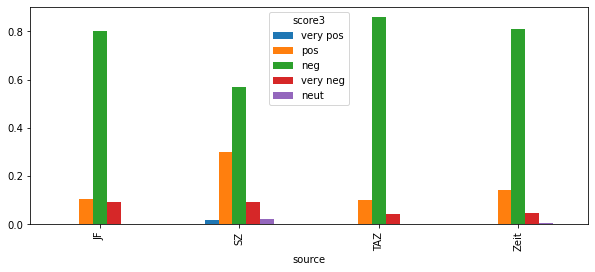

In [52]:
# Visualizing the new labeling scheme
all_df.groupby('source').score3.value_counts(normalize=True).unstack()[['very pos', 'pos', 'neg', 'very neg', 'neut']].plot.bar(figsize=(10,4))
plt.show

#### Discussion
- The majority of the articles are still grouped under pos/neg with only a few as very neg and even fewer as very pos. Because there are so few positive articles it is hard to evenly expand the score range on very pos/very neg without losing all the very pos articles. 
- I would say this improves our sense of the articles somewhat, but does not nearly fix the issues with Sentiws.

### A brief side step
- Because of the number of articles that are influenced by only a few words, let's check on the trends for articles that have a large number of weighted words.

In [57]:
# finding the word count for the weighted words 
all_df['words_c'] = all_df['words'].map(lambda x: len(x))

# making a sub df of all articles with informative word counts 20 or over
vdesc = all_df[all_df.words_c >= 20]
print("There are 791 non-null values")
vdesc.groupby('source').score3.value_counts()

# We lost all neutral values (makes sense, they were usually due to no weighted words) 
# and all the very pos articles
# Distribution is still very heavily skewed towards pos/neg
# Interestingly, comparing JF and Taz, who both had fairly few pos articles, JF only has one (and 3 very neg!)
# while Taz kept 7.

There are 791 non-null values


source  score3  
JF      neg          31
        very neg      3
        pos           1
SZ      neg         230
        pos          62
        very neg      5
TAZ     neg          71
        pos           7
        very neg      2
Zeit    neg         326
        pos          41
        very neg     12
Name: score3, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

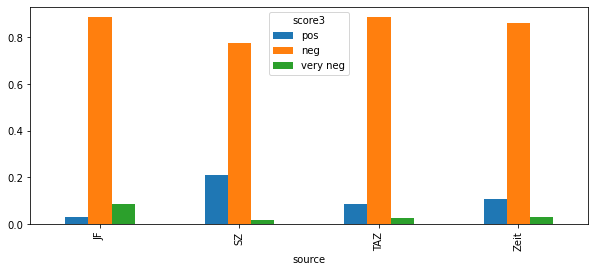

In [59]:
# Visualizing it
vdesc.groupby('source').score3.value_counts(normalize=True).unstack()[['pos', 'neg', 'very neg']].plot.bar(figsize=(10,4))
plt.show

#### Discussion
- It seems the trends are still the same for articles with many weighted words, it would seem that the overwelmingly negative trend persists regardless of how many words have weights. This is good news as it is consistant with the rest of the data, but still does not help much in terms of improving Sentiws.

## Word based analysis
### A deeper look at weighted words
- It seems that without a much bigger overhall - i,e including negation analysis - Sentiws is not going to get too much more exact. Because of time constraints I am instead going to take a deeper look at the words, both with weights and overall, in the positive and negative articles and compare across sentiemnt and sources.

In [64]:
# dataframes by sentiment - using score 3, since it is the most refined, if only barely
pos_df = all_df[all_df.score3 == 'pos']
#pos2.head()
neg_df = all_df[all_df.score3=='neg']
#neg2.head() 
vneg_df = all_df[all_df.score3=='very neg']
#vneg.head()
vpos_df = all_df[all_df.score3=='very pos']
#vpos.head()
neut_df = all_df[all_df.score3=='neut']
#neut_df.head()

In [69]:
# First off, what are the most common pos vs neg words? We will leave off very pos/neg and neut for now
pos_wrds = pos_df.words.tolist()
neg_wrds = neg_df.words.tolist()
neg_w = [item for sublist in neg_wrds for item in sublist]
pos_w = [item for sublist in pos_wrds for item in sublist]

counts = Counter(pos_w)
mc_pos = counts.most_common(20)
print("These are the most common weighted words in the positive articles:")
print(mc_pos)
print() 
c = Counter(neg_w)
mc_neg = c.most_common(20)
print("These are the most common weighted words in the negative articles:")
print(mc_neg)
# Second most common is the first most common in pos...

These are the most common weighted words in the positive articles:
[('helfen', 80), ('kurzen', 74), ('Bund', 70), ('Unterstützung', 53), ('lernen', 50), ('nächsten', 50), ('Flucht', 42), ('unterstützen', 41), ('Hilfe', 39), ('erhalten', 36), ('erklärt', 33), ('Ausbildung', 32), ('schaffen', 32), ('hilft', 31), ('Ziel', 29), ('Spenden', 28), ('unterstützt', 27), ('guten', 27), ('größte', 27), ('erreichen', 26)]

These are the most common weighted words in the negative articles:
[('kurzen', 436), ('Problem', 241), ('Hilfe', 221), ('schaffen', 191), ('Probleme', 171), ('helfen', 168), ('Flucht', 163), ('Krieg', 160), ('erklärt', 155), ('Angst', 151), ('Bund', 141), ('Schutz', 135), ('Gewalt', 132), ('Sicherheit', 129), ('Kritik', 128), ('erhalten', 122), ('Ziel', 118), ('Lösung', 117), ('erklärte', 116), ('Unterstützung', 116)]


In [71]:
# Clearly there is a good deal of overlap, so both must be a mix of postive and negative weights, let's take a look

neg20 = []
for w,c in mc_neg:
    neg20.append(w)
       
pos20 = []
for w,c in mc_pos:
    pos20.append(w)

print("These are the words with their weights for the negative:")
for doc in nlp.pipe(neg20):
    print([(token.text, token._.sentiws) for token in doc])

print()
print("These are the words with their weights for the postive:")
for doc in nlp.pipe(pos20):
    print([(token.text, token._.sentiws) for token in doc])
    
# NOTE: I have no idea why there are some with a None weight, as I filtered to exlude these right at the beginning..

These are the words with their weights for the negative:
[('kurzen', None)]
[('Problem', -0.3865)]
[('Hilfe', 0.004)]
[('schaffen', 0.004)]
[('Probleme', -0.3865)]
[('helfen', 0.373)]
[('Flucht', -0.0048)]
[('Krieg', -0.5364)]
[('erklärt', 0.004)]
[('Angst', -0.514)]
[('Bund', 0.004)]
[('Schutz', 0.004)]
[('Gewalt', -0.5363)]
[('Sicherheit', 0.004)]
[('Kritik', -0.5308)]
[('erhalten', 0.004)]
[('Ziel', 0.004)]
[('Lösung', 0.004)]
[('erklärte', 0.004)]
[('Unterstützung', 0.004)]

These are the words with their weights for the postive:
[('helfen', 0.373)]
[('kurzen', None)]
[('Bund', 0.004)]
[('Unterstützung', 0.004)]
[('lernen', 0.2492)]
[('nächsten', None)]
[('Flucht', -0.0048)]
[('unterstützen', 0.004)]
[('Hilfe', 0.004)]
[('erhalten', 0.004)]
[('erklärt', 0.004)]
[('Ausbildung', 0.004)]
[('schaffen', 0.004)]
[('hilft', 0.373)]
[('Ziel', 0.004)]
[('Spenden', 0.004)]
[('unterstützt', 0.004)]
[('guten', 0.3716)]
[('größte', 0.3694)]
[('erreichen', 0.004)]


wordcloud for weighted word in negative articles


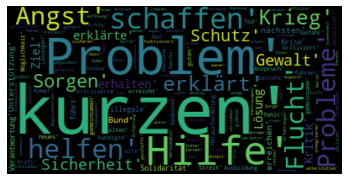

In [77]:
# Note very easy to see what's going one, let's try a word cloud!
wordcloud = WordCloud().generate(str(neg_w))

print("Wordcloud for weighted word in negative articles")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Notes: kurzen is short... There are some words that are clearly negative: Gewalt: violence; Krieg: war; Angst: fear
# but Schutz is protection, helfen is to help and sicherheit is safety so it is a mixed bag

Wordcloud for weighted word in postive articles


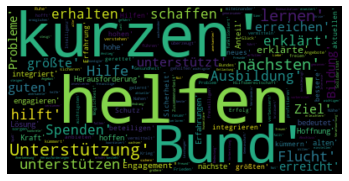

In [78]:
wordcloud = WordCloud().generate(str(pos_w))

print("Wordcloud for weighted word in postive articles")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# Notes: again short showed up... Here to help makes sense, Bund: league/union/coalition; Unterstützung: support

Wordcloud from all words in the negative articles


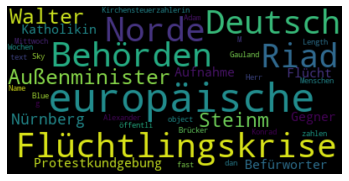

In [79]:
# But what about all the words, not just the ones with weights? 
txt = neg.text
stop.update(['dpa', 'Berlin', 'München', 'ONLINE', 'Stanisław', 'Gądecki', 'Franz', 'Peter', 'Frank',  'v', 'dtype'])
wordcloud = WordCloud(stopwords=stop).generate(str(txt))

print("Wordcloud from all words in the negative articles")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Wordcloud from all words in the postive articles


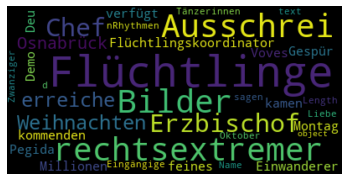

In [81]:
text = pos.text
wordcloud = WordCloud(stopwords=stop).generate(str(text))


print("Wordcloud from all words in the postive articles")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- I think this comparision (all text) is much more interesting than only the weighted words! For instance, in the negative articles we find "Flüchtlingskrise": refugee crisis vs "Flüchtlinge": refugees. This could indicate that the crisis itself is a more negative topic than refugees themselves. Interestingly "right-wing extremist" (rechtsextremer) is in the positive words, as is Pegida - a right-wing extremist group. Foreign minister is in the negative words, as is European, German and public authorities. 

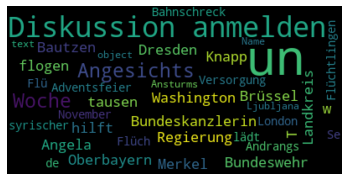

In [207]:
t = vpos.text
wordcloud = WordCloud(stopwords=stop).generate(str(t))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

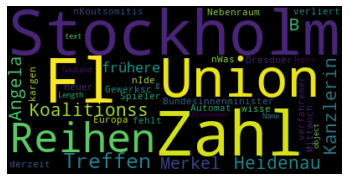

In [208]:
tx = vneg.text
wordcloud = WordCloud(stopwords=stop).generate(str(tx))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
# But what about most common words per souce?
# Since there was so little difference between the score with flüchtling and without, and because of the null values 
# which I would prefer not to drop, I am going to use the orginial score

#Creating subdata frames by source and pos/neg
zeit_pos = all_df[(all_df['source']=='Zeit') & (all_df['score']=='pos')]
zeit_neg = all_df[(all_df['source']=='Zeit') & (all_df['score']=='neg')]
taz_pos = all_df[(all_df['source']=='TAZ') & (all_df['score']=='pos')]
taz_neg = all_df[(all_df['source']=='TAZ') & (all_df['score']=='neg')]
sz_pos = all_df[(all_df['source']=='SZ') & (all_df['score']=='pos')]
sz_neg = all_df[(all_df['source']=='SZ') & (all_df['score']=='neg')]
jf_pos = all_df[(all_df['source']=='JF') & (all_df['score']=='pos')]
jf_neg = all_df[(all_df['source']=='JF') & (all_df['score']=='neg')]

In [67]:
# pos/neg word lists for all sources 
nw_z = zeit_neg.words.tolist()
pw_z = zeit_pos.words.tolist()
negw_zeit = [item for sublist in nw_z for item in sublist]
posw_zeit = [item for sublist in pw_z for item in sublist]

nw_tz = taz_neg.words.tolist()
pw_tz = taz_pos.words.tolist()
negw_taz = [item for sublist in nw_tz for item in sublist]
posw_taz = [item for sublist in pw_tz for item in sublist]

nw_sz = sz_neg.words.tolist()
pw_sz = sz_pos.words.tolist()
negw_sz = [item for sublist in nw_sz for item in sublist]
posw_sz = [item for sublist in pw_sz for item in sublist]

nw_jf = jf_neg.words.tolist()
pw_jf = jf_pos.words.tolist()
negw_jf = [item for sublist in nw_jf for item in sublist]
posw_jf = [item for sublist in pw_jf for item in sublist]

In [70]:
# Defining custom function to get most common 20 words and their sentiws scores
def most_common20_score(lst):
    l = []
    counts = Counter(lst)
    mc20 = counts.most_common(20)
    for w,c in mc20:
        l.append(w)
    for doc in nlp.pipe(l):
        print([(token.text, token._.sentiws) for token in doc])

In [73]:
print("These are the most common words in the negative Zeit articles:")
MCneg_zeit = most_common20_score(negw_zeit)
print(MCneg_zeit)

print("These are the most common words in the positive Zeit articles:")
MCpos_zeit = most_common20_score(posw_zeit)
print(MCpos_zeit)

These are the most common words in the negative Zeit articles:
[('kurzen', None)]
[('Problem', -0.3865)]
[('Angst', -0.514)]
[('Hilfe', 0.004)]
[('Gewalt', -0.5363)]
[('schaffen', 0.004)]
[('Krieg', -0.5364)]
[('Probleme', -0.3865)]
[('helfen', 0.373)]
[('erreichen', 0.004)]
[('Flucht', -0.0048)]
[('erklärt', 0.004)]
[('Unterstützung', 0.004)]
[('Schutz', 0.004)]
[('Sicherheit', 0.004)]
[('Kritik', -0.5308)]
[('Krise', -0.3621)]
[('nächsten', None)]
[('Solidarität', 0.004)]
[('Lösung', 0.004)]
None
These are the most common words in the positive Zeit articles:
[('kurzen', None)]
[('Bildung', 0.004)]
[('lernen', 0.2492)]
[('größte', 0.3694)]
[('nächsten', None)]
[('Anteil', 0.004)]
[('Intelligenz', 0.004)]
[('Flucht', -0.0048)]
[('helfen', 0.373)]
[('bessere', 0.3716)]
[('gerettet', 0.004)]
[('miteinander', 0.3697)]
[('schaffen', 0.004)]
[('größten', None)]
[('erreichen', 0.004)]
[('erklärt', 0.004)]
[('Ziel', 0.004)]
[('guten', 0.3716)]
[('alten', None)]
[('Sicherheit', 0.004)]
None


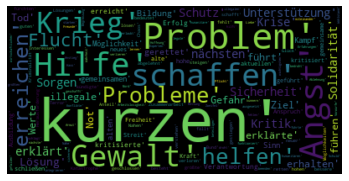

In [171]:
wordcloud = WordCloud().generate(str(negw_zeit))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

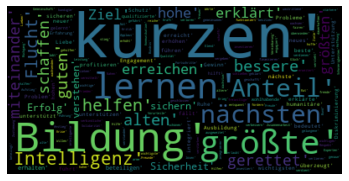

In [172]:
wordcloud = WordCloud().generate(str(posw_zeit))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [74]:
print("These are the most common words in the negative Taz articles:")
MCneg_taz = most_common20_score(negw_taz)
print(MCneg_taz)

print("These are the most common words in the positive Taz articles:")
MCpos_taz = most_common20_score(posw_taz)
print(MCpos_taz)

These are the most common words in the negative Taz articles:
[('Hilfe', 0.004)]
[('erklärt', 0.004)]
[('Krieg', -0.5364)]
[('Flucht', -0.0048)]
[('Angst', -0.514)]
[('helfen', 0.373)]
[('Problem', -0.3865)]
[('schaffen', 0.004)]
[('Probleme', -0.3865)]
[('erhalten', 0.004)]
[('Sicherheit', 0.004)]
[('Schutz', 0.004)]
[('Gewalt', -0.5363)]
[('Anspruch', 0.004)]
[('Ziel', 0.004)]
[('Kritik', -0.5308)]
[('Kampf', -0.5372)]
[('Unterstützung', 0.004)]
[('hilft', 0.373)]
[('Bund', 0.004)]
None
These are the most common words in the positive Taz articles:
[('Nahen', None)]
[('Glück', 0.2452)]
[('lernen', 0.2492)]
[('hohen', 0.004)]
[('Flucht', -0.0048)]
[('Hoffnung', 0.2038)]
[('erklärt', 0.004)]
[('guten', 0.3716)]
[('Freund', 0.0116)]
[('Last', -0.0048)]
[('unterstützt', 0.004)]
[('Spaß', 0.2823)]
[('unterstützen', 0.004)]
[('kümmert', 0.2016)]
[('droht', -0.3503)]
[('neues', 0.004)]
[('lobt', 0.4445)]
[('Sicherheit', 0.004)]
[('funktioniert', 0.004)]
[('hoffen', 0.2318)]
None


In [75]:
print("These are the most common words in the negative SZ articles:")
MCneg_sz = most_common20_score(negw_sz)
print(MCneg_sz)

print("These are the most common words in the positive SZ articles:")
MCpos_sz = most_common20_score(posw_sz)
print(MCpos_sz)

These are the most common words in the negative SZ articles:
[('Problem', -0.3865)]
[('Hilfe', 0.004)]
[('Bund', 0.004)]
[('Probleme', -0.3865)]
[('schaffen', 0.004)]
[('helfen', 0.373)]
[('Flucht', -0.0048)]
[('erklärte', 0.004)]
[('Kritik', -0.5308)]
[('Angst', -0.514)]
[('erklärt', 0.004)]
[('Ausbildung', 0.004)]
[('Schutz', 0.004)]
[('Ziel', 0.004)]
[('Gewalt', -0.5363)]
[('Lösung', 0.004)]
[('erhalten', 0.004)]
[('nächsten', None)]
[('Krieg', -0.5364)]
[('Sicherheit', 0.004)]
None
These are the most common words in the positive SZ articles:
[('Bund', 0.004)]
[('helfen', 0.373)]
[('Unterstützung', 0.004)]
[('nächsten', None)]
[('Hilfe', 0.004)]
[('unterstützen', 0.004)]
[('lernen', 0.2492)]
[('Spenden', 0.004)]
[('erhalten', 0.004)]
[('hilft', 0.373)]
[('Flucht', -0.0048)]
[('Ausbildung', 0.004)]
[('aktuellen', None)]
[('unterstützt', 0.004)]
[('erklärt', 0.004)]
[('Engagement', 0.2157)]
[('engagieren', 0.004)]
[('Ziel', 0.004)]
[('Herausforderung', -0.0048)]
[('schaffen', 0.004)]


In [77]:
print("These are the most common words in the negative JF articles:")
MCneg_jf = most_common20_score(negw_jf)
print(MCneg_jf)

print("These are the most common words in the positive JF articles:")
MCpos_jf = most_common20_score(posw_jf)
print(MCpos_jf)

These are the most common words in the negative JF articles:
[('illegale', -0.3479)]
[('Kritik', -0.5308)]
[('Krieg', -0.5364)]
[('Problem', -0.3865)]
[('illegalen', -0.3479)]
[('Sicherheit', 0.004)]
[('Gewalt', -0.5363)]
[('Probleme', -0.3865)]
[('schaffen', 0.004)]
[('Anspruch', 0.004)]
[('führen', 0.004)]
[('Interessen', 0.004)]
[('Schutz', 0.004)]
[('Diskriminierung', -0.0048)]
[('erklärt', 0.004)]
[('illegaler', -0.3479)]
[('Pflicht', -0.3577)]
[('alten', None)]
[('bedeutet', 0.004)]
[('Unterstützung', 0.004)]
None
These are the most common words in the positive JF articles:
[('Problem', -0.3865)]
[('integriert', 0.0908)]
[('Herausforderung', -0.0048)]
[('helfen', 0.373)]
[('geschafft', 0.004)]
[('Zweifel', -0.0048)]
[('Probleme', -0.3865)]
[('Vertrauen', 0.3512)]
[('wachsen', 0.3607)]
[('Ausbildung', 0.004)]
[('kostenloses', 0.004)]
[('kostenlose', 0.004)]
[('chaotischen', None)]
[('absolute', 0.2418)]
[('erschöpft', -0.0377)]
[('größte', 0.3694)]
[('stärkeres', None)]
[('behinde

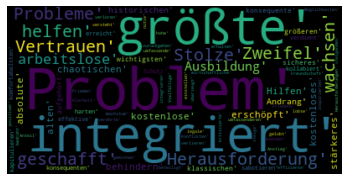

In [173]:
wordcloud = WordCloud().generate(str(posw_jf))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

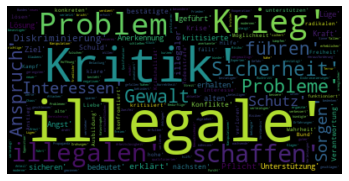

In [174]:
wordcloud = WordCloud().generate(str(negw_jf))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

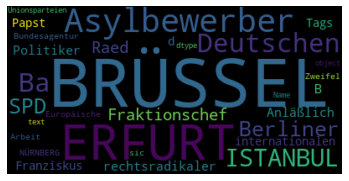

In [198]:
txt = jf_pos.text
wordcloud = WordCloud(stopwords=stop).generate(str(txt))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [79]:
# Finding most common trigrams containing flüchtling per source
# making lists of pos/neg text
txt_pos_z = zeit_pos.text.map(lambda x: nltk.word_tokenize(x))
txt_pos_zeit = [item for sublist in txt_pos_z for item in sublist]
txt_neg_z = zeit_neg.text.map(lambda x: nltk.word_tokenize(x))
txt_neg_zeit = [item for sublist in txt_neg_z for item in sublist]

In [99]:
def flüchtlingen_trigrams(lst):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    tri_finder = TrigramCollocationFinder.from_words(lst)
    # Only trigrams that appear 3+ times
    tri_finder.apply_freq_filter(2)
    # Only the ones containing my word
    my_filter2 = lambda *w: 'Flüchtlingen' not in w
    tri_finder.apply_ngram_filter(my_filter2)
    print(tri_finder.nbest(trigram_measures.pmi, 3))

In [100]:
flüchtlingen_trigrams(txt_neg_zeit)

[('Seenot', 'geratenen', 'Flüchtlingen'), ('Flüchtlingen', 'vorübergehend', 'eingestellt'), ('weiteren', '20.000', 'Flüchtlingen'), ('20.000', 'Flüchtlingen', 'innerhalb'), ('rund', '300', 'Flüchtlingen'), ('Durchwinkens', 'von', 'Flüchtlingen'), ('Flüchtlingen', 'im', 'Winter'), ('Andrangs', 'von', 'Flüchtlingen'), ('bei', 'syrischen', 'Flüchtlingen'), ('Aufnahme', 'von', 'Flüchtlingen')]


In [101]:
flüchtlingen_trigrams(txt_pos_zeit)

[('Umverteilung', 'von', 'Flüchtlingen'), ('Aufnahme', 'von', 'Flüchtlingen'), ('Versorgung', 'von', 'Flüchtlingen'), ('Einreise', 'von', 'Flüchtlingen'), ('von', 'Flüchtlingen', 'innerhalb'), ('Tausende', 'von', 'Flüchtlingen'), ('Flüchtlingen', 'innerhalb', 'der'), ('Flüchtlingen', 'aus', 'dem'), ('von', 'Flüchtlingen', 'aus'), ('von', 'Flüchtlingen', 'in')]


In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tri_finder = TrigramCollocationFinder.from_words(ughh)
# Only trigrams that appear 3+ times
tri_finder.apply_freq_filter(3)
# Only the ones containing my word
my_filter2 = lambda *w: 'Flüchtlingen' not in w
tri_finder.apply_ngram_filter(my_filter2)

print(tri_finder.nbest(trigram_measures.pmi, 20))

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tri_finder = TrigramCollocationFinder.from_words(ughh)
# Only trigrams that appear 3+ times
tri_finder.apply_freq_filter(3)
# Only the ones containing my word
my_filter3 = lambda *w: 'Flüchtlinge' not in w
tri_finder.apply_ngram_filter(my_filter3)

print(tri_finder.nbest(trigram_measures.pmi, 20))